## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import descartes
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
import simplekml
from pykml import parser
import fiona

## Work directory

In [2]:
work_dir = "../Data/maharashtra_state_data/"

## Reading file

In [3]:
fiona.drvsupport.supported_drivers['KML'] = 'rw'
kml_gdf = gpd.read_file(work_dir + 'Hyderabad_map.kml', driver='KML')

In [4]:
kml_gdf

,Name,Description,geometry
0,Hyderabad,,"POLYGON Z ((78.47089 17.40028 0.00000, 78.4708..."


In [5]:
# Reading Shapefile

maharashtra_gdf = gpd.read_file(work_dir + 'maharashtra_state_file.shp')

In [6]:
maharashtra_gdf.head()

,DST_ID,DISTRICT,STATE,POPULATION,EDUCATION%,geometry
0,341,Dhule,MAHARASHTRA,314,12,"POLYGON ((74.20773 21.93558, 74.35860 21.91001..."
1,345,Amravati,MAHARASHTRA,34235,3,"POLYGON ((78.44017 21.56075, 78.46526 21.53776..."
2,346,Nagpur,MAHARASHTRA,54701,75,"POLYGON ((79.28021 21.67177, 79.47013 21.61316..."
3,348,Bhandara,MAHARASHTRA,41848,85,"POLYGON ((79.57979 21.51545, 79.83173 21.45281..."
4,350,Jalgaon,MAHARASHTRA,6532,29,"POLYGON ((75.29046 21.36305, 75.37971 21.32246..."


## Checking columns of KML file

In [7]:
kml_gdf.columns

Index(['Name', 'Description', 'geometry'], dtype='object')

## Converting 'Polygon' values of geometry column into 'Polygon Z' values of shapefile

In [8]:
maharashtra_gdf['geometry'] = maharashtra_gdf['geometry'].apply(lambda p: Polygon([(x, y, 0) for x, y in p.exterior.coords]))

## Creating required columns in KML file

In [9]:
kml_gdf['DST_ID'] = 483
kml_gdf['DISTRICT'] = 'Hyderabad'
kml_gdf['STATE'] = 'Telangana'
kml_gdf['POPULATION'] = 90000
kml_gdf['EDUCATION%'] = 100

## Selecting and arranging only required columns

In [10]:
kml_gdf = kml_gdf[['DST_ID', 'DISTRICT', 'STATE', 'POPULATION', 'EDUCATION%', 'geometry']]

In [11]:
maharashtra_gdf.columns

Index(['DST_ID', 'DISTRICT', 'STATE', 'POPULATION', 'EDUCATION%', 'geometry'], dtype='object')

## Plotting Marashtra map before merge

<Axes: >

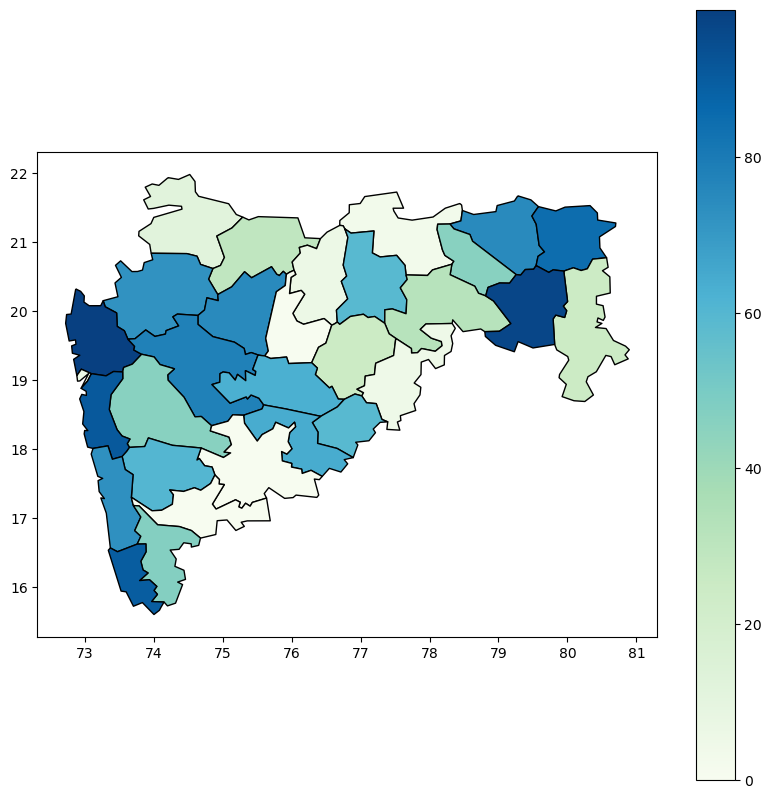

In [12]:
maharashtra_gdf.plot(figsize = (10,10),legend=True, column = 'EDUCATION%', cmap = 'GnBu', edgecolor = 'black')

## Merging both files

In [13]:
maharashtra_gdf = maharashtra_gdf.merge(kml_gdf, how = 'outer')

## Checking unique values of 'DISTRICT' column

In [14]:
maharashtra_gdf['DISTRICT'].unique()

array(['Dhule', 'Amravati', 'Nagpur', 'Bhandara', 'Jalgaon', 'Wardha',
       'Buldana', 'Akola', 'Nashik', 'Gadchiroli', 'Yavatmal',
       'Chandrapur', 'Aurangabad', 'Jalna', 'Thane', 'Ahmadnagar',
       'Parbhani', 'Nanded', 'Pune', 'Bid', 'Greater Bombay', 'Raigarh',
       'Latur', 'Osmanabad', 'Solapur', 'Satara', 'Ratnagiri', 'Sangli',
       'Kolhapur', 'Sindhudurg', 'Hyderabad'], dtype=object)

## Plotting figure

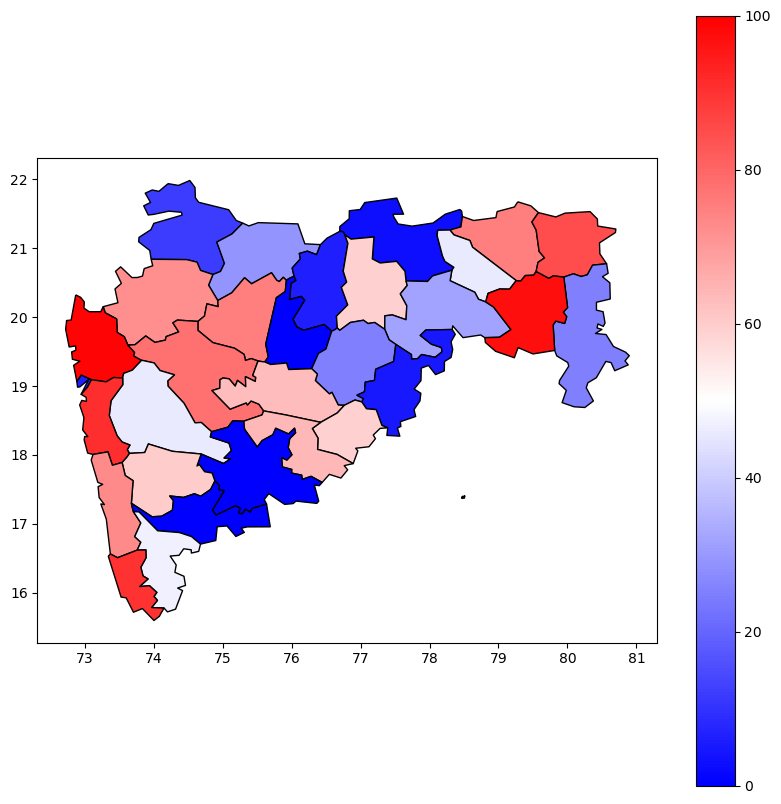

In [15]:
ax = maharashtra_gdf.plot(figsize = (10,10), column = 'EDUCATION%',legend=True,
                          cmap = 'bwr',facecolor = '#00000050', edgecolor = 'black')
# ax.set_xlim(78,79)
# ax.set_ylim(16.5,18)

# Calculating AREA of all districts

### The units of measurement returned by the gdf.area function depend on the units of measurement used in the coordinate reference system (CRS) of the GeoDataFrame.

### If the CRS uses a planar projection (e.g., UTM), the area will be returned in the units of that projection, such as square meters or square feet. If the CRS uses a geographic projection (e.g., WGS84), the area will be returned in the units of the coordinate system, such as decimal degrees or radians.

In [16]:
# Selecting 'DISTRICT' column as index 

area_gdf = maharashtra_gdf.set_index("DISTRICT")

In [17]:
# calculating area of all districts

area_gdf["area"] = area_gdf.area
area_gdf["area"].head()

DISTRICT
Dhule       1.137022
Amravati    1.078834
Nagpur      0.838848
Bhandara    0.824176
Jalgaon     0.998181
Name: area, dtype: float64

# Calculating polygon boundary 

In [18]:
area_gdf['boundary'] = area_gdf.boundary
area_gdf['boundary'].head()

DISTRICT
Dhule       LINESTRING Z (74.20773 21.93558 0.00000, 74.35...
Amravati    LINESTRING Z (78.44017 21.56075 0.00000, 78.46...
Nagpur      LINESTRING Z (79.28021 21.67177 0.00000, 79.47...
Bhandara    LINESTRING Z (79.57979 21.51545 0.00000, 79.83...
Jalgaon     LINESTRING Z (75.29046 21.36305 0.00000, 75.37...
Name: boundary, dtype: geometry

# Calculating polygon centroid

In [19]:
area_gdf['centroid'] = area_gdf.centroid
area_gdf['centroid'].head()

DISTRICT
Dhule       POINT (74.49218 21.29109)
Amravati    POINT (77.60240 21.14133)
Nagpur      POINT (79.11232 21.11923)
Bhandara    POINT (80.02974 21.06723)
Jalgaon     POINT (75.52399 20.89936)
Name: centroid, dtype: geometry

# Measuring distance

In [20]:
# Selecting a starting point from which we need to find out distances for all points

first_point = area_gdf['centroid'][0]

In [21]:
area_gdf['distance'] = area_gdf['centroid'].distance(first_point)
area_gdf['distance'].head()

DISTRICT
Dhule       0.000000
Amravati    3.113831
Nagpur      4.623341
Bhandara    5.542086
Jalgaon     1.103671
Name: distance, dtype: float64

In [22]:
area_gdf.columns

Index(['DST_ID', 'STATE', 'POPULATION', 'EDUCATION%', 'geometry', 'area',
       'boundary', 'centroid', 'distance'],
      dtype='object')

## to calculate the average of the distances measured above, access the ‘distance’ column and call the mean() method on it

In [23]:
area_gdf['distance'].mean()

3.363182755209005

# Making maps

<Axes: >

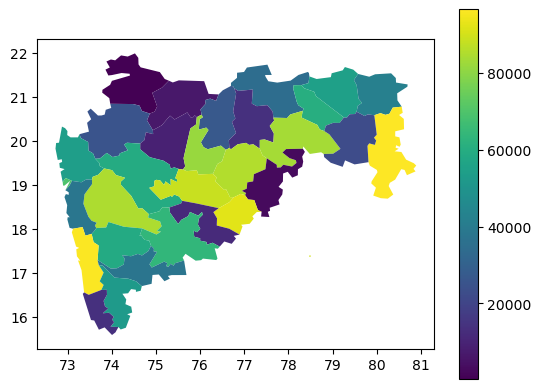

In [24]:
area_gdf.plot("POPULATION", legend=True)

# GeoDataFrame.explore()

### Using GeoDataFrame.explore(), which behaves in the same way plot() does but returns an interactive map instead.

In [25]:
area_gdf.explore('POPULATION', legend=True)

# GeoDataFrame.set_geometry() function

### the active geometry (GeoDataFrame.set_geometry) to centroids, we can plot the same data using point geometry.

<Axes: >

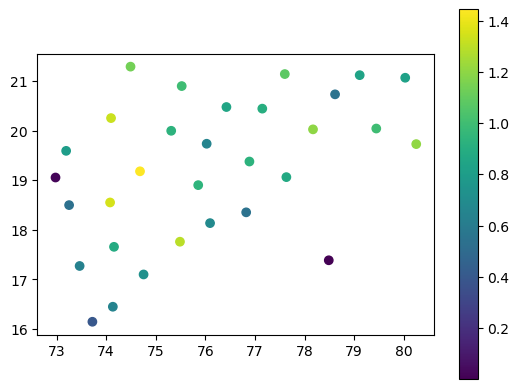

In [26]:
geometry_gdf = area_gdf.set_geometry("centroid")
geometry_gdf.plot("area", legend=True)

### we can also layer both GeoSeries on top of each other. We just need to use one plot as an axis for the other.

<Axes: >

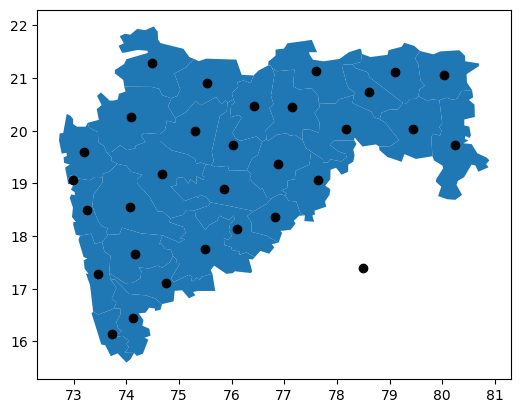

In [27]:
ax = geometry_gdf["geometry"].plot()
geometry_gdf["centroid"].plot(ax=ax, color="black")

# Geometry creation

In [28]:
area_gdf = area_gdf.set_geometry("geometry")

## Convex hull

In [29]:
area_gdf["convex_hull"] = area_gdf.convex_hull

<Axes: >

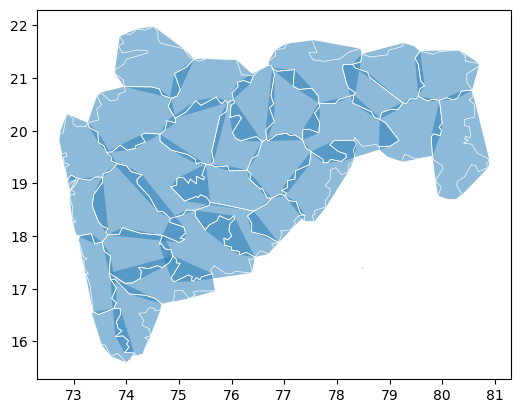

In [30]:
ax = area_gdf["convex_hull"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
area_gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

## Buffer

In [31]:
# buffering the active geometry by 10 000 feet (geometry is already in feet)

area_gdf["buffered"] = area_gdf.buffer(10000)

# buffering the centroid geometry by 10 000 feet (geometry is already in feet)

area_gdf["buffered_centroid"] = area_gdf["centroid"].buffer(10000)

<Axes: >

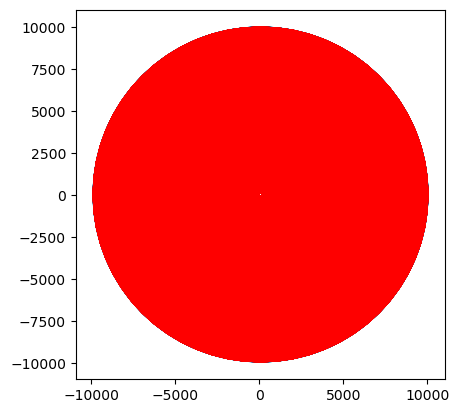

In [32]:
# saving the first plot as an axis and setting alpha (transparency) to 0.5

ax = area_gdf["buffered"].plot(alpha=.5)  

# passing the first plot as an axis to the second

area_gdf["buffered_centroid"].plot(ax=ax, color="red", alpha=.5) 

# passing the first plot and setting linewitdth to 0.5

area_gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  

# Geometry relations

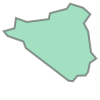

In [33]:
Nagpur = area_gdf.loc["Nagpur", "geometry"]
Nagpur

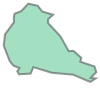

In [34]:
Pune = area_gdf.loc["Pune", "geometry"]
Pune

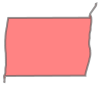

In [35]:
Hyderabad = area_gdf.loc["Hyderabad", "geometry"]
Hyderabad

In [36]:
type(Nagpur)

shapely.geometry.polygon.Polygon

In [37]:
area_gdf["buffered"].intersects(Nagpur).head()

DISTRICT
Dhule       True
Amravati    True
Nagpur      True
Bhandara    True
Jalgaon     True
dtype: bool

In [38]:
area_gdf["within"] = area_gdf["buffered_centroid"].within(area_gdf)
area_gdf["within"].head()

DISTRICT
Dhule       False
Amravati    False
Nagpur      False
Bhandara    False
Jalgaon     False
Name: within, dtype: bool

<Axes: >

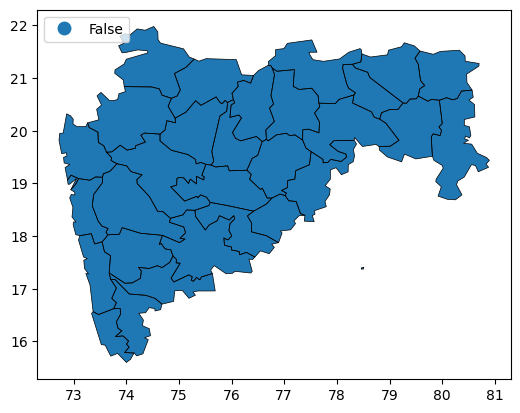

In [39]:
geo_gdf = area_gdf.set_geometry("buffered_centroid")

# using categorical plot and setting the position of the legend

ax = area_gdf.plot("within", legend=True, categorical=True, legend_kwds={'loc': "upper left"})  

# passing the first plot and setting linewitdth to 0.5

area_gdf["boundary"].plot(ax=ax, color="black", linewidth=.5)  